In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import tensorflow as tf
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras import datasets,layers,models
from tqdm import tqdm
from typing import List

In [3]:
def read_photo_path_data(path = '/content/drive/My Drive/aueb/') -> pd.DataFrame:
  """
  Reads the file paths of every jpg file in the chosen directory
  Returns a DataFrame Object
  """
  path = path +'**/*.jpg' # Includes all jpgs from all subdirectories
  file_paths = glob.glob(path, recursive = True)
  return pd.DataFrame(file_paths)


def extract_id_from_file_path(dataframe: pd.DataFrame,column_location=0) -> pd.Series:
  """
  Extracts the product id (4 digit number) contained in the file path
  Column location is used to locate the position of the path column in
  the dataframe,default in the first column (0).
  """
  regex = r"/(\d+)_"
  return dataframe.iloc[:,column_location].str.extract(regex)


def data_preproccessing(dataframe: pd.DataFrame) -> pd.DataFrame:
  """
  Extracts the ID from the file path and filters out any products
  with only one picture
  """
  dataframe.rename(columns = {0:'path'},inplace = True)
  dataframe['id'] = extract_id_from_file_path(dataframe)
  #dataframe = filter_products_with_single_photos(dataframe)
  return dataframe


def extract_label_from_dataframe(df: pd.DataFrame) -> pd.Series:
  """ Extracts the image label from path in the FIRST COLUMN.
  It is assumed that image is named as {class_label}_{counter}.jpg"""
  return df.iloc[:,0].str.split("/").str[-1].str.split("_").str[0]


def images_to_ndarray(photo_path : str, IMG_SIZE = (150,150))-> np.array:
  """
  The function reads the images supplied by 
  photo_paths parameter. The function reads an image from path,
  resizes it and turns into grayscale
  """
  nd_array = cv.imread(photo_path)
  return cv.resize(nd_array, IMG_SIZE)

In [4]:
# Hyper Parameters
IMG_SIZE = (150,150)
TEST_SIZE = 0.25
BATCH_SIZE = 32
EPOCHS = 15

In [76]:
photo_path_data = read_photo_path_data(path = '/content/drive/My Drive/aueb/compressed/') # read image paths
photo_path_data['class_label'] = extract_label_from_dataframe(photo_path_data) # extract label and assign it to column
photo_path_data.rename(columns = {0:'path'},inplace = True)
photo_path_data.head(1000)


,path,class_label
0,/content/drive/My Drive/aueb/compressed/Images...,SKIP KAPSOULES 20 MEZOURES SPRING FRESH
1,/content/drive/My Drive/aueb/compressed/Images...,SKIP KAPSOULES 20 MEZOURES SPRING FRESH
2,/content/drive/My Drive/aueb/compressed/Images...,SKIP KAPSOULES 20 MEZOURES SPRING FRESH
3,/content/drive/My Drive/aueb/compressed/Images...,SKIP KAPSOULES 20 MEZOURES SPRING FRESH
4,/content/drive/My Drive/aueb/compressed/Images...,SKIP KAPSOULES 20 MEZOURES SPRING FRESH
...,...,...
995,/content/drive/My Drive/aueb/compressed/Images...,KRIKRI YOGURT
996,/content/drive/My Drive/aueb/compressed/Images...,KRIKRI YOGURT
997,/content/drive/My Drive/aueb/compressed/Images...,KRIKRI YOGURT
998,/content/drive/My Drive/aueb/compressed/Images...,KRIKRI YOGURT


In [6]:
X = [images_to_ndarray(im, IMG_SIZE = IMG_SIZE) for im in tqdm(photo_path_data['path'])]
X = np.array(X)
Y = np.array(photo_path_data['class_label'])

100%|██████████| 3693/3693 [18:28<00:00,  3.33it/s]


In [7]:
encoder = OrdinalEncoder()
Y = encoder.fit_transform(Y.reshape(-1,1))

In [8]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X,Y,test_size = TEST_SIZE, stratify = Y, random_state =42)
X_TRAIN = X_TRAIN/255
X_TEST = X_TEST/255

In [10]:
print(f"Number of Training Images {X_TRAIN.shape[0]}")
print(f"Number of Test Images {X_TEST.shape[0]}")

Number of Training Images 2769
Number of Test Images 924


In [19]:
print(type(X_TRAIN))
print(type(Y_TRAIN))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [21]:
# Convolution Model Building
# Custom Network Hooray
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (150,150,3)))
conv_model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
conv_model.add(layers.MaxPooling2D(2,2))
conv_model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
conv_model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
conv_model.add(layers.MaxPooling2D(2,2))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dense(4096,activation = 'relu'))
conv_model.add(layers.Dense(len(np.unique(Y_TRAIN)),activation = 'softmax'))
conv_model.summary()
conv_model.compile(optimizer = 'adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 146, 146, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 71, 71, 64)        36928     
                                                                 
 conv2d_11 (Conv2D)          (None, 69, 69, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 34, 34, 64)       0         
 2D)                                                  

In [22]:
from tensorflow.python.keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor   = 'accuracy', # which metric we want to use as criterion to stop training
    min_delta = 0, # Minimum change in the monitored quantity to qualify as an improvement
    patience  = 3, # we 3 epochs before stopping
    verbose   = 1, # verbosity level
    mode      = 'auto',
    restore_best_weights = True)

In [23]:
history = conv_model.fit(X_TRAIN,Y_TRAIN,
                         epochs = EPOCHS,
                         validation_split = 0.25,
                         callbacks = [es])

Epoch 1/15
65/65 [==============================] - 17s 251ms/step - loss: 3.5060 - accuracy: 0.2958 - val_loss: 1.5752 - val_accuracy: 0.6436
Epoch 2/15
65/65 [==============================] - 11s 166ms/step - loss: 0.6799 - accuracy: 0.8613 - val_loss: 1.6784 - val_accuracy: 0.6508
Epoch 3/15
65/65 [==============================] - 11s 166ms/step - loss: 0.1469 - accuracy: 0.9658 - val_loss: 1.1063 - val_accuracy: 0.8139
Epoch 4/15
65/65 [==============================] - 11s 166ms/step - loss: 0.0675 - accuracy: 0.9894 - val_loss: 0.8555 - val_accuracy: 0.8312
Epoch 5/15
65/65 [==============================] - 11s 168ms/step - loss: 0.0302 - accuracy: 0.9937 - val_loss: 1.1157 - val_accuracy: 0.8167
Epoch 6/15
65/65 [==============================] - 11s 167ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.8187 - val_accuracy: 0.8773
Epoch 7/15
65/65 [==============================] - 11s 167ms/step - loss: 2.6141e-04 - accuracy: 1.0000 - val_loss: 0.8545 - val_accuracy: 0.

In [96]:
def get_predictions_from_model(nnmodel, X_TEST : np.array ) -> np.array:
  """
  Returns the predictions for the convolutional model.
  Takes as parameters the X_TEST holdout dataset
  """
  predictions = nnmodel.predict(X_TEST)
  return np.argmax(predictions, axis = 1) # Get the most probable class


def get_original_labels(transformed_labels: np.array,encoder: OrdinalEncoder) -> np.array:
  """
  The function returns the original labels (before ordinal encoding).
  """
  return encoder.inverse_transform(transformed_labels.reshape(-1,1))


def plot_image(Image_array: np.array,
                predictions_array: pd.DataFrame,
                index: int
                ) -> None:
  fig, ax = plt.subplots(figsize = (8,8))
  ax.imshow(Image_array[index])
  plt.title(f"Predicted Label {predictions_array.iloc[index,0]}") # First Columns contains correct Predictions
  plt.axis('off')

def plot_multiple_images(Image_array: np.array,
                         predictions_array: pd.DataFrame,
                         indexes: List,
                         figsize: tuple,
                         ) -> None:
  fig = plt.figure(figsize = figsize)
  ROWS = len(indexes)
  for i,index in enumerate(indexes):

    fig.add_subplot(ROWS,1,(i+1)) # show images in single row
    plt.imshow(Image_array[index])
    plt.axis('off')
    plt.title(f"Predicted Label: {predictions_array.loc[index,'Ypred']}, True Label: {predictions_array.loc[index,'Ytrue']}")




In [57]:
predictions = get_predictions_from_model(conv_model,X_TEST)
label_pred = get_original_labels(predictions,encoder)
label_true = get_original_labels(Y_TEST,encoder)

predictions_dataframe = pd.DataFrame({'Ytrue':label_true.reshape(-1), 'Ypred':label_pred.reshape(-1)})
correct_predictions = predictions_dataframe[predictions_dataframe['Ytrue']==predictions_dataframe['Ypred']]
false_predictions = predictions_dataframe[predictions_dataframe['Ytrue']!=predictions_dataframe['Ypred']]

In [87]:
correct_predictions

,Ytrue,Ypred
0,Ariel,Ariel
1,ALLOTINO LEYKOS OINOS 500ML 1.92,ALLOTINO LEYKOS OINOS 500ML 1.92
2,FAGEgreen big,FAGEgreen big
3,KAISER MPIRA 330ML 1.20,KAISER MPIRA 330ML 1.20
4,SPRITE LEMON 500ML 0.80,SPRITE LEMON 500ML 0.80
...,...,...
918,KLINEX XLORINI ULTRA LEVANTE,KLINEX XLORINI ULTRA LEVANTE
920,KAISER MPIRA 330ML 1.20,KAISER MPIRA 330ML 1.20
921,DODONI blue,DODONI blue
922,RED BULL 250 ML 0.98,RED BULL 250 ML 0.98


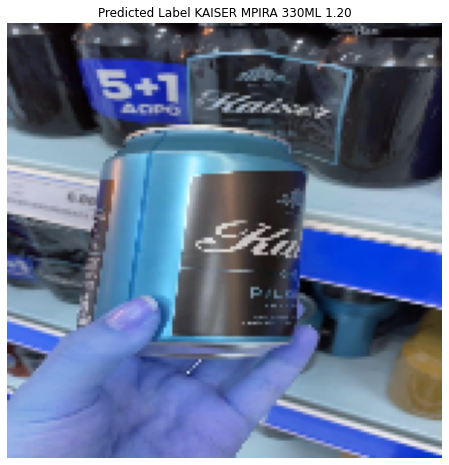

In [86]:
plot_image(X_TEST,predictions_dataframe, 920)

In [58]:
false_predictions_index = false_predictions.index
correct_predictions_index = correct_predictions.index
predictions_index = predictions_dataframe.index

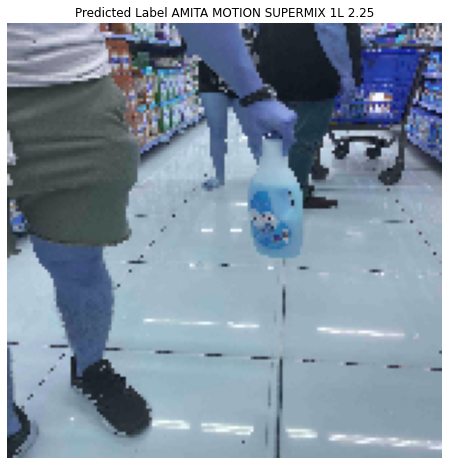

In [59]:
#Plot some false predictions
plot_image(X_TEST, false_predictions, false_predictions_index[0])

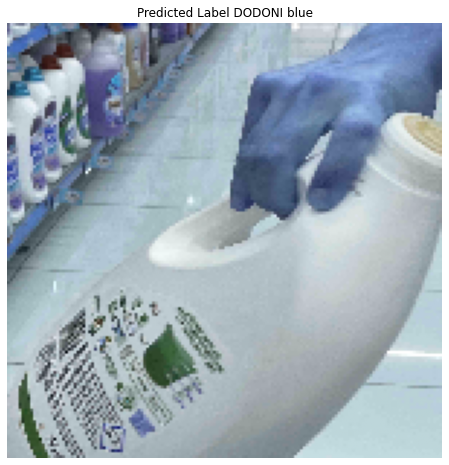

In [38]:
plot_image(X_TEST, false_predictions, false_predictions_index[10])

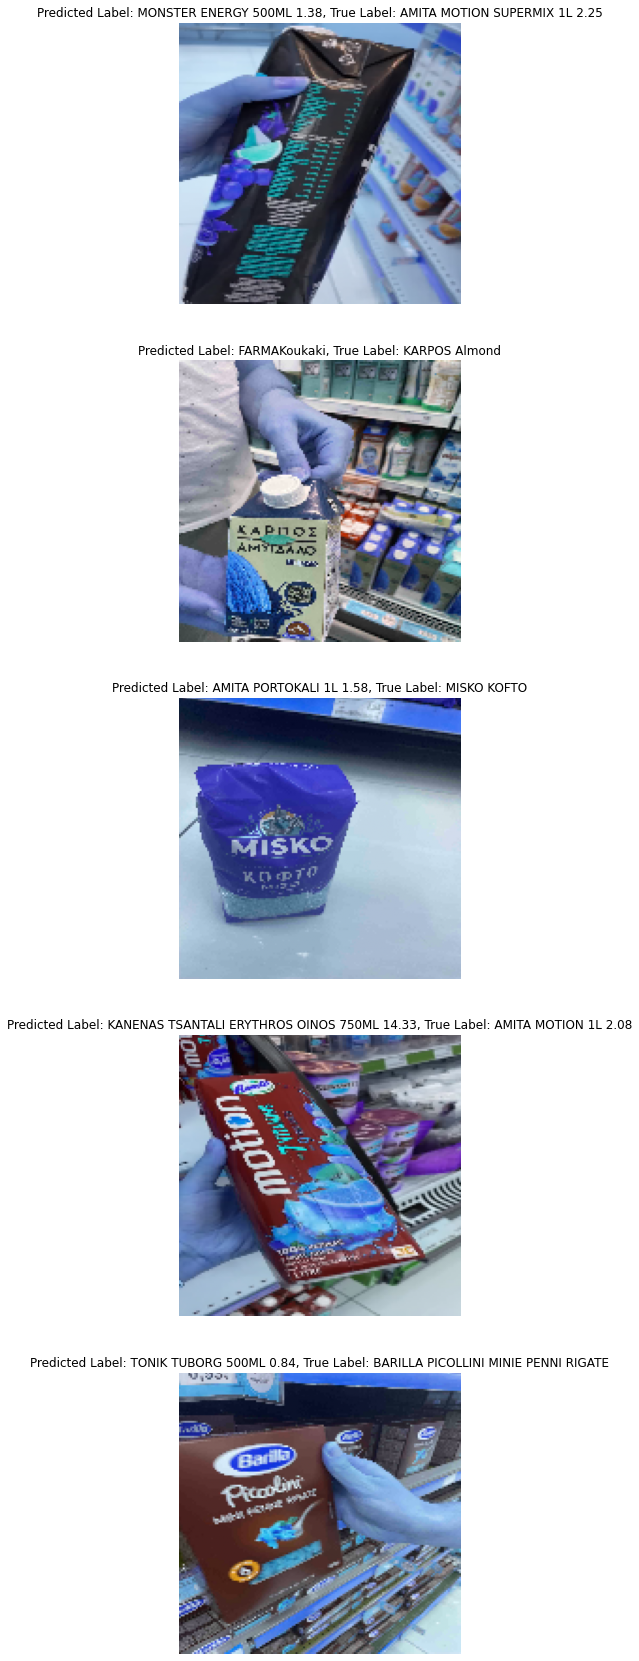

In [97]:
plot_multiple_images(X_TEST, false_predictions, false_predictions_index[5:10], figsize = (30,30))

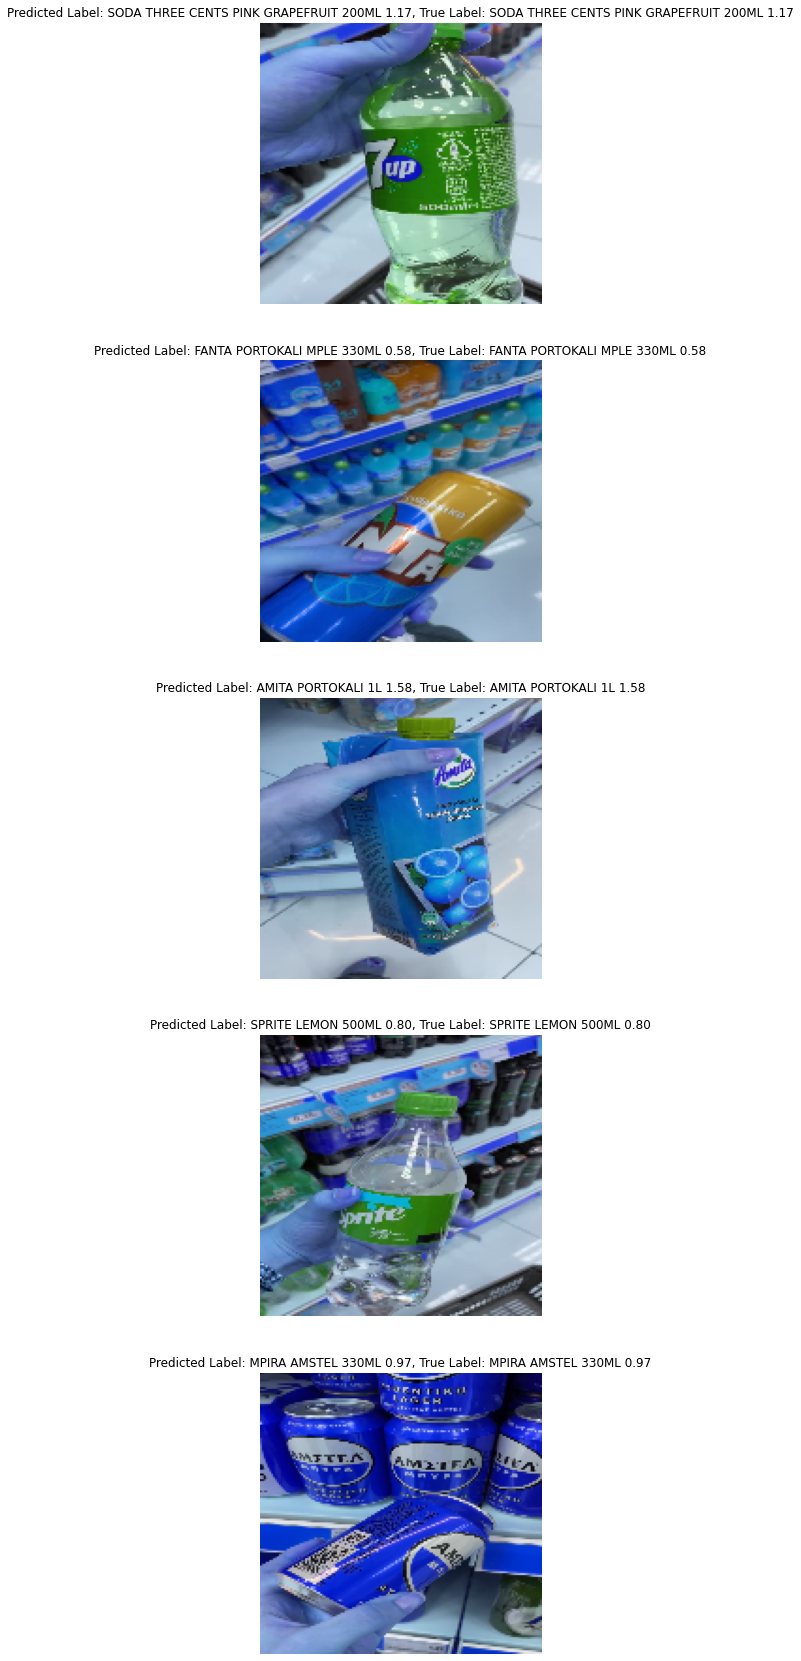

In [98]:
# Correct Predictions
plot_multiple_images(X_TEST, correct_predictions, correct_predictions_index[10:15], figsize = (30,30))

In [ ]:
#Train VGG
from tensorflow.keras.applications import VGG16

In [ ]:
vgg16model = VGG16(include_top = False)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
#|vgg16model.summary()
for layer in vgg16model.layers:
  layer.trainable = False